*******
# EDA

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn.linear_model as lm

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from scipy.stats import binned_statistic
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set(rc = {'axes.titlesize': 28,
             'axes.labelsize': 26,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'figure.figsize': (12, 8)})

df_p = pd.read_pickle('C:/Users/Marko/Documents/ECON 490 AML Data/final_income.pkl')
df_prep = df_p.drop(columns = ['marst', 'in_wage'])


<AxesSubplot:title={'center':'Binary Wage Income Distribution'}, xlabel='Wage Income Above $33,132', ylabel='Count'>

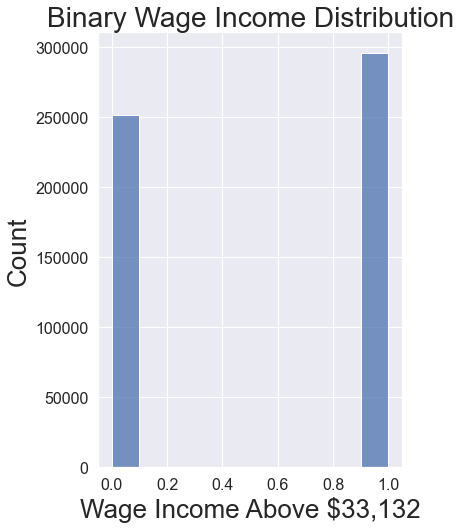

In [2]:
# Figure 1: Making a historgram of the label
plt.figure()
plt.subplot(1,2,1)
plt.title('Binary Wage Income Distribution')
plt.xlabel('Wage Income Above $33,132')
sns.histplot(x = 'bin_wage', data = df_prep, bins = 10)

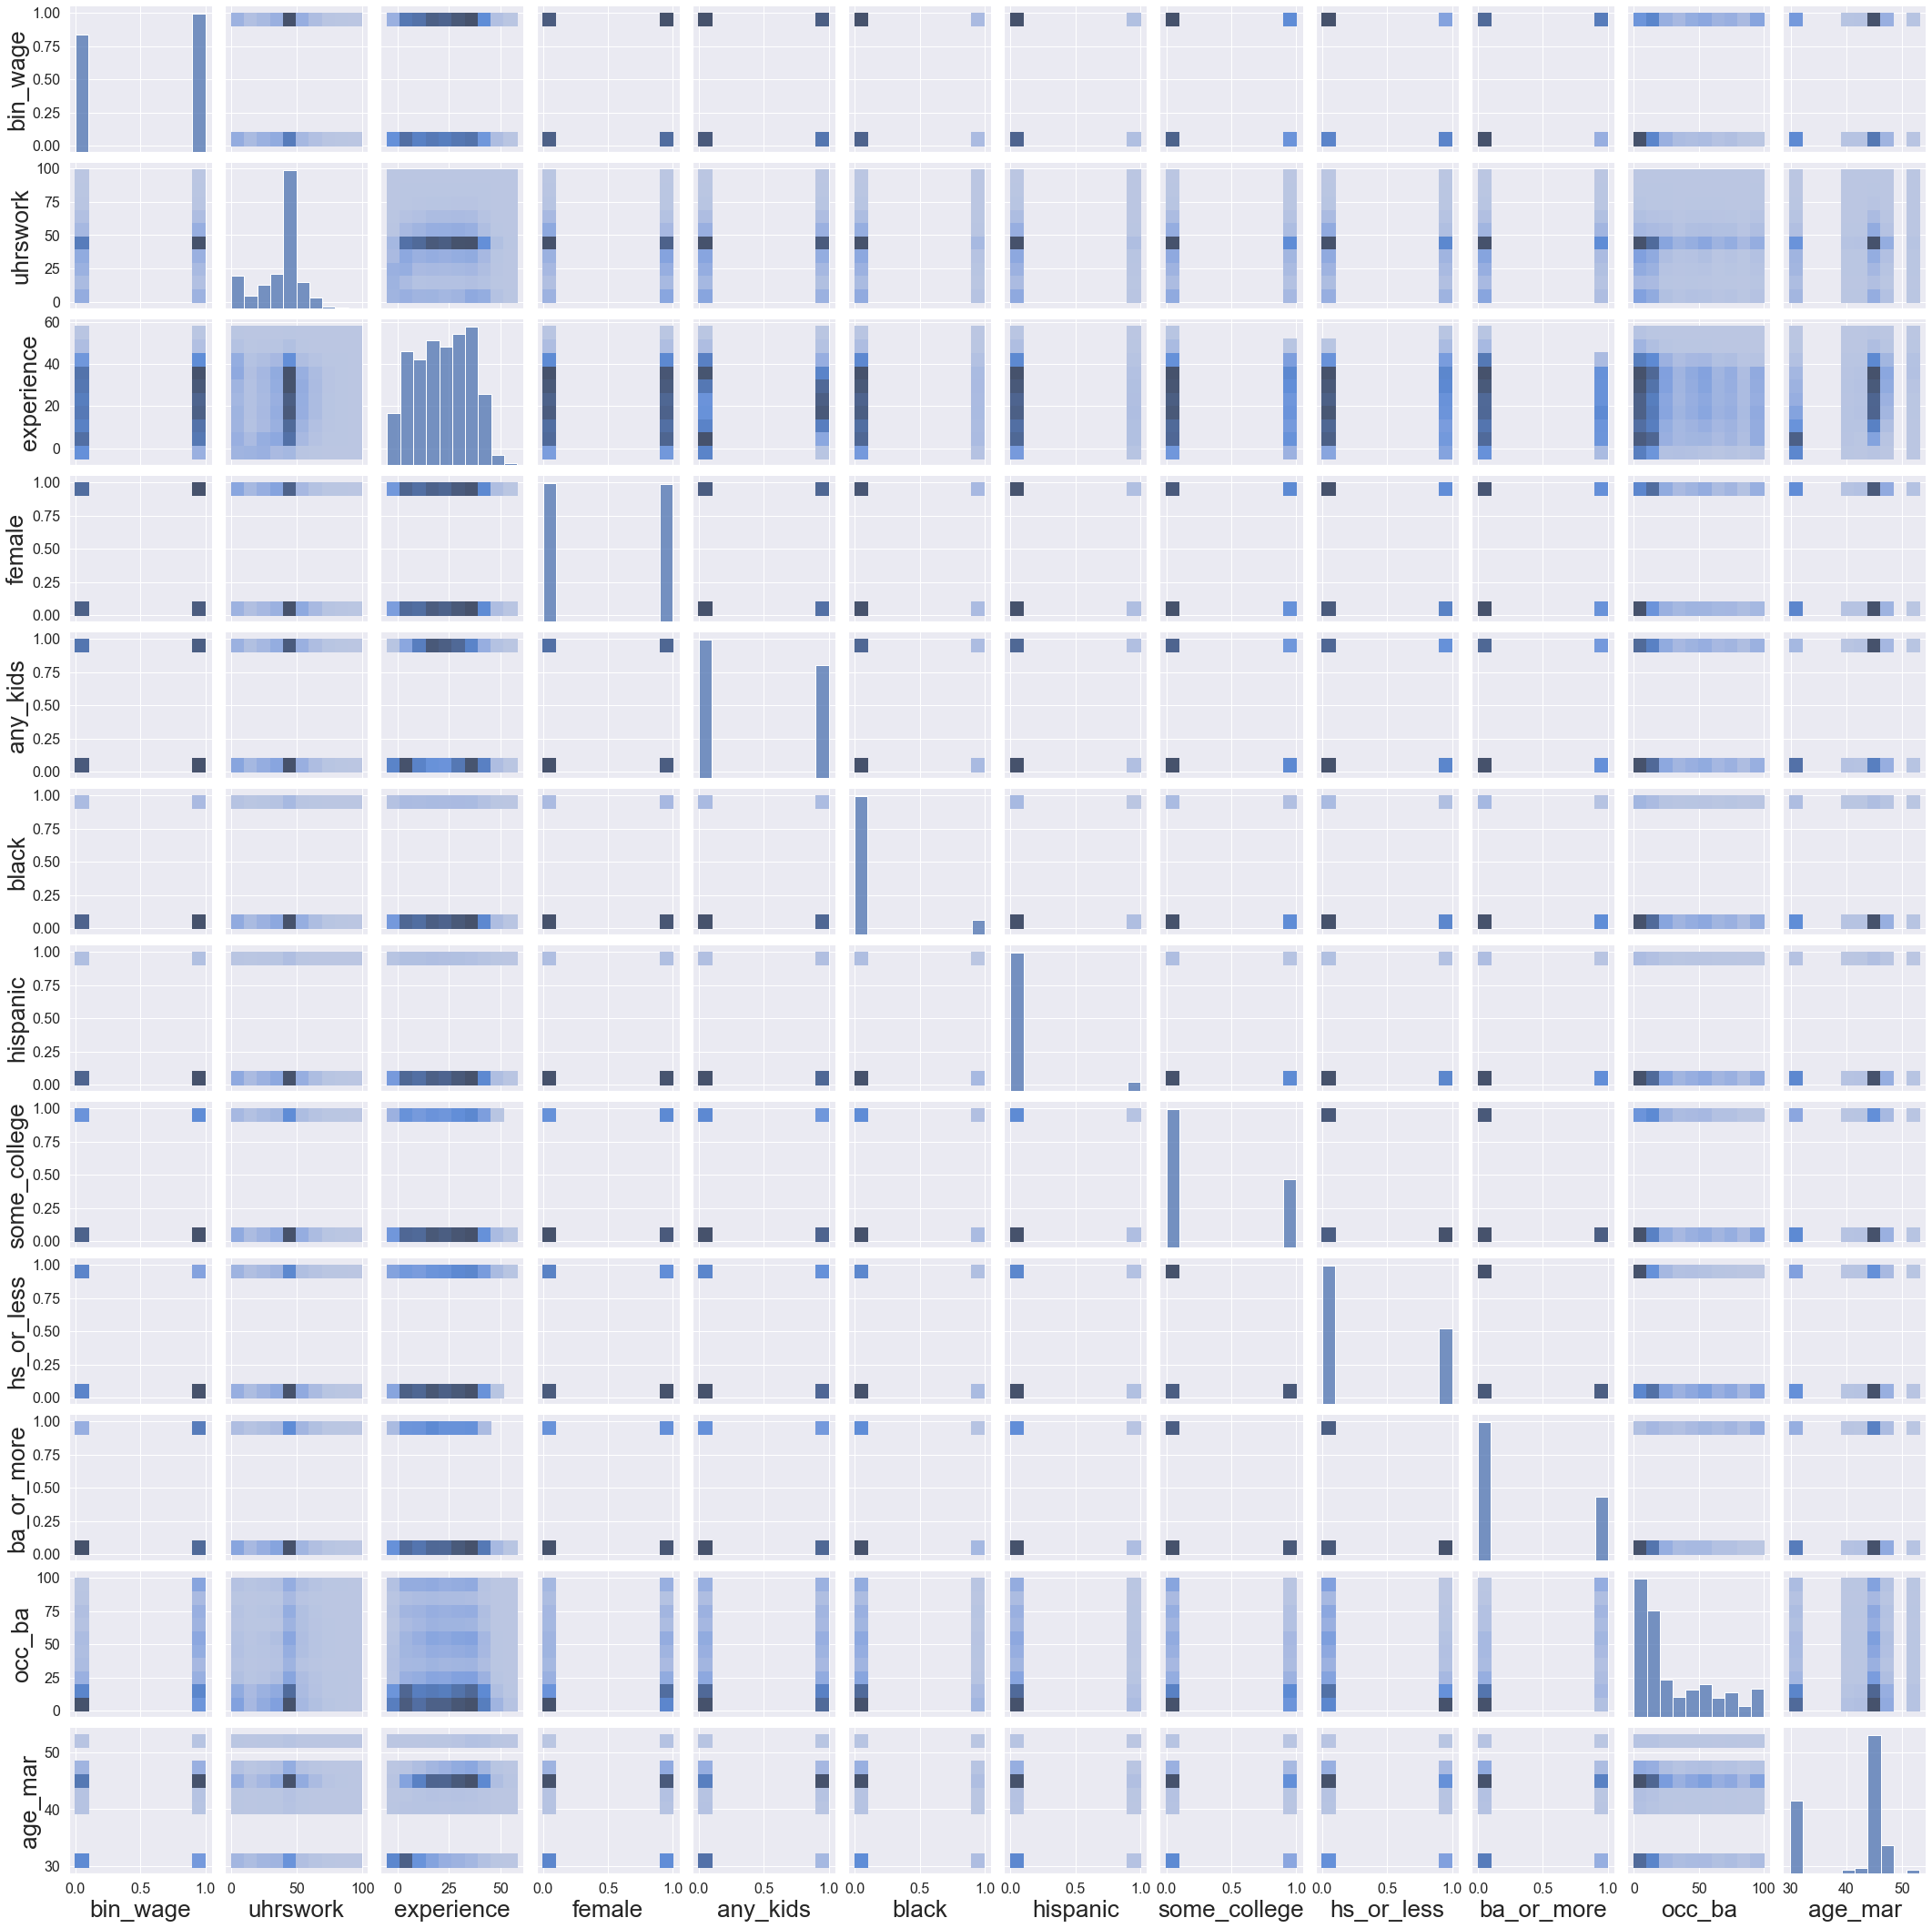

In [3]:
# Figure 2: Making a pair-plot to test for any evident correlation between features or if transformations would be needed.
sns.pairplot(data = df_prep, kind = 'hist', plot_kws = {'bins': 10}, diag_kws = {'bins': 10})
plt.show()

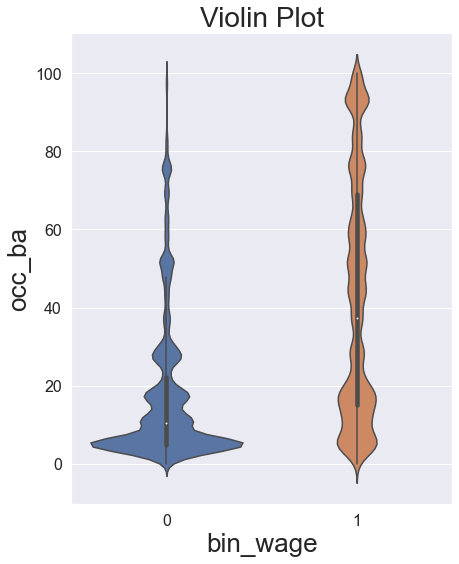

In [4]:
# Figure 3: Making a violin plot
# Comparing the most interesting feature wihh the label.
# Also, the occ_ba as potentially being the most signifcant feature.

plt.subplot(1,2,2)
plt.title("Violin Plot")
plt.ylabel("Percentage with Bachelor's degree group by Occupation")
plt.xlabel('Binary Wage')
sns.violinplot(data = df_prep, x = 'bin_wage', y = 'occ_ba')

plt.tight_layout()

*******
# Inference

In [5]:
# for the confusion matrix
sns.set_style("white")

y = df_prep['bin_wage']
x = df_prep.drop(columns = 'bin_wage')


#I needed to change the train_size to 0.1 to get a rasonable training set size because I initially had 2/3 as train_size.
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.1, random_state = 490)
x_train_std = x_train.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)
x_test_std = x_test.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)

x_train_std = sm.add_constant(x_train_std)
x_test_std  = sm.add_constant(x_test_std)
x_train     = sm.add_constant(x_train)
x_test      = sm.add_constant(x_test)

In [6]:
#Print head
df_prep.head()

,,,bin_wage,uhrswork,experience,female,any_kids,black,hispanic,some_college,hs_or_less,ba_or_more,occ_ba,age_mar
id,occ2010,ind1990,,,,,,,,,,,,
301,5310,831,1,40,45,1,0,0,0,1,0,0,17.136427,44.313648
401,4000,832,0,32,43,1,1,1,0,0,1,0,4.784706,46.979363
402,5350,662,0,40,20,0,0,1,0,0,1,0,12.652608,29.822957
701,5620,600,0,20,8,1,0,0,0,0,1,0,6.125904,29.822957
801,5940,741,0,35,23,1,1,0,0,1,0,0,29.568023,44.313648


In [7]:
#Print shape
df_prep.shape

(546804, 12)

In [8]:
#Print info
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 546804 entries, (301, 5310, 831) to (46867202, 4230, 761)
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bin_wage      546804 non-null  int32  
 1   uhrswork      546804 non-null  int64  
 2   experience    546804 non-null  int64  
 3   female        546804 non-null  int32  
 4   any_kids      546804 non-null  int32  
 5   black         546804 non-null  int32  
 6   hispanic      546804 non-null  int32  
 7   some_college  546804 non-null  int32  
 8   hs_or_less    546804 non-null  int32  
 9   ba_or_more    546804 non-null  int32  
 10  occ_ba        546804 non-null  float64
 11  age_mar       546804 non-null  float64
dtypes: float64(2), int32(8), int64(2)
memory usage: 61.8 MB


In [9]:
%%time
param_grid = {
    'C': 10.0**np.arange(-5, 5, step = 1)
}

lr_cv = lm.LogisticRegression(penalty = 'l1', solver = 'liblinear',
                              max_iter = 1e3, random_state = 490)
grid_search = GridSearchCV(lr_cv, param_grid, 
                          cv = 5, 
                          scoring = 'accuracy',
                          n_jobs = 10)
grid_search.fit(x_train_std, y_train)
best = grid_search.best_params_
best

Wall time: 9.48 s


{'C': 100.0}

In [10]:
# I had to change l1_ratio to be 1 because I completely misunderstood what l1_ratio was.
# l1_ratio should be 1 becasue it would be LASSO, but a value of 0 would be elasticnet.

fit_logit_reg = sm.Logit(y_train, x_train_std).fit_regularized(alpha = 1/best['C'], L1_wt = 1, qc_tol = 1e3)
print(fit_logit_reg.params)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5780879494311103
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
const           0.250919
uhrswork        0.172438
experience      0.155916
female          0.000000
any_kids        0.013937
black           0.057513
hispanic       -0.019891
some_college    0.000000
hs_or_less     -0.186490
ba_or_more      0.105739
occ_ba          0.868471
age_mar         0.086077
dtype: float64


In [11]:
#Drop female and some_colllege since the coefficients are 0.

beta = fit_logit_reg.params
beta.index[beta == 0]

Index(['female', 'some_college'], dtype='object')

In [12]:
#Non-regularized model

x_train_std_trim = x_train_std.loc[:, ~x_train_std.columns.isin(beta.index[beta == 0])]
x_test_std_trim = x_test_std.loc[:, ~x_test_std.columns.isin(beta.index[beta == 0])]

In [13]:
fit_std_final = sm.Logit(y_train, x_train_std_trim).fit()
print(fit_std_final.summary())

Optimization terminated successfully.
         Current function value: 0.578659
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               bin_wage   No. Observations:                54680
Model:                          Logit   Df Residuals:                    54670
Method:                           MLE   Df Model:                            9
Date:                Fri, 14 May 2021   Pseudo R-squ.:                  0.1614
Time:                        22:35:59   Log-Likelihood:                -31641.
converged:                       True   LL-Null:                       -37733.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2526      0.010     25.315      0.000       0.233       0.272
uhrswork       0.1551      0.

In [14]:
# Accuracy of the inference model, apart from reporting the Pseudo R-Squared.

fit_logit = lm.LogisticRegression().fit(x_train_std_trim, y_train)
yhat = fit_logit.predict(x_test_std_trim)
acc_logit = np.mean(y_test == yhat)
acc_logit

0.6920288382602758

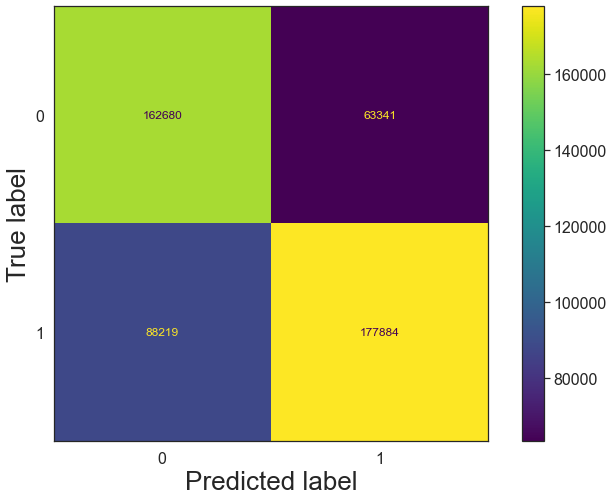

In [15]:
plot_confusion_matrix(fit_logit, x_test_std_trim, y_test)
plt.show()

In [16]:
# Sensitivity of the Inference model

im_sy = 177884/(88219 + 177884)
im_sy

0.6684779953626979

*******
# Prediction

## Additional Model 1: Random Forest

In [17]:
le = LabelEncoder()
le.fit(y)

y_train = le.transform(y_train)
y_test  = le.transform(y_test)

clf_bag_tree = RandomForestClassifier(n_estimators = 500,
                          random_state = 490,
                          max_features = 'sqrt',
                          oob_score = True,
                          n_jobs = 10,
                          verbose = 1)
clf_bag_tree.fit(x_train, y_train)

acc_bag_tree = clf_bag_tree.score(x_test, y_test)
acc_bag_tree

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    4.3s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   13.5s finished


0.7311551560175891

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    4.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   13.2s finished


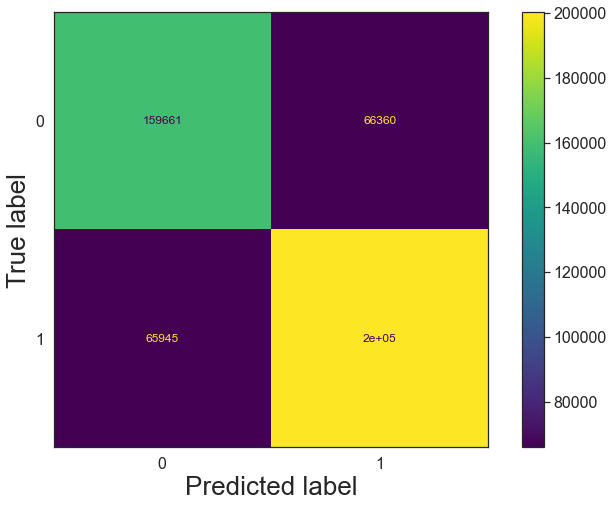

In [18]:
# Confusion matrix of Random Forest

plot_confusion_matrix(clf_bag_tree, x_test, y_test)
plt.show()

In [19]:
# Sensitivity of the Random Forest

rf_sy = 200000/(65945 + 200000)
rf_sy

0.7520351952471376

## Additional Model 2: XGBoost

In [20]:
x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_train_std, y_train,
                                                                           train_size = 2/3,
                                                                           random_state = 490)

In [21]:
reg_xgb = xgb.XGBRegressor(n_estimators = 500,
                          max_depth = 2, 
                          learning = 1,
                          random_state = 490,
                          use_label_encoder = False)

reg_xgb.fit(x_train_train, y_train_train,
           eval_set = [(x_train_test, y_train_test)],
           early_stopping_rounds = 4)

[22:36:36] WARNING: ..\src\learner.cc:541: 
Parameters: { learning } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:0.47313
[1]	validation_0-rmse:0.45898
[2]	validation_0-rmse:0.45059
[3]	validation_0-rmse:0.44544
[4]	validation_0-rmse:0.44211
[5]	validation_0-rmse:0.43981
[6]	validation_0-rmse:0.43822
[7]	validation_0-rmse:0.43733
[8]	validation_0-rmse:0.43627
[9]	validation_0-rmse:0.43567
[10]	validation_0-rmse:0.43481
[11]	validation_0-rmse:0.43406
[12]	validation_0-rmse:0.43379
[13]	validation_0-rmse:0.43289
[14]	validation_0-rmse:0.43248
[15]	validation_0-rmse:0.43183
[16]	validation_0-rmse:0.43030
[17]	validation_0-rmse:0.42893
[18]	validation_0-rmse:0.42849
[19]	validation_0-rmse:0.42800
[20]	validation_0-rmse:0.42517
[21]	validation_0-rmse:0.42399


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='', learning=1,
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=490,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [22]:
best_reg_xgb = reg_xgb.get_booster().best_iteration
print("Best Iteration: {}".format(best_reg_xgb))

Best Iteration: 396


In [23]:
reg_xgb_2 = xgb.XGBClassifier(n_estimators = best_reg_xgb, 
                          max_depth = 2, 
                          learning = 1,
                          random_state = 490,
                          use_label_encoder = False)
reg_xgb_2.fit(x_train_train, y_train_train,
             eval_set = [(x_train_test, y_train_test)],
           early_stopping_rounds = 4)

[22:36:38] WARNING: ..\src\learner.cc:541: 
Parameters: { learning } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:36:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.64081
[1]	validation_0-logloss:0.61292
[2]	validation_0-logloss:0.59542
[3]	validation_0-logloss:0.58466
[4]	validation_0-logloss:0.57719
[5]	validation_0-logloss:0.57105
[6]	validation_0-logloss:0.56757
[7]	validation_0-logloss:0.56390
[8]	validation_0-logloss:0.56120
[9]	validation_0-logloss:0.55878
[10]	validation_0-logloss:0.55670
[11]	validation_0-logloss:0.55530
[12]	validation_0-logl

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='', learning=1,
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=396, n_jobs=8, num_parallel_tree=1, random_state=490,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [24]:
acc_xgb = reg_xgb_2.score(x_train_test, y_train_test)
acc_xgb

0.7883359850770835

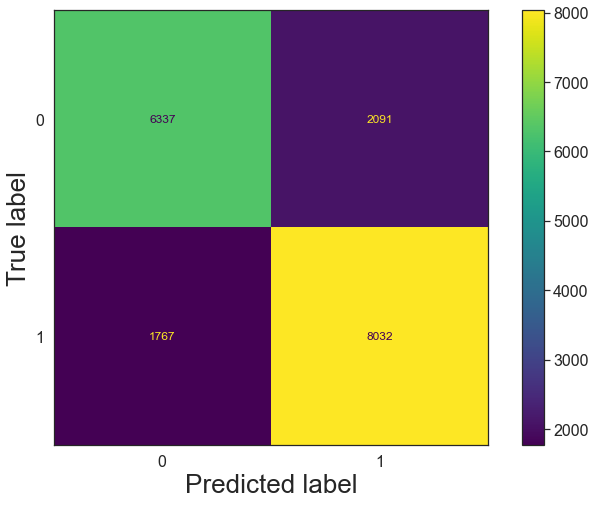

In [25]:
# Confusion matrix for XGBoost

plot_confusion_matrix(reg_xgb_2, x_train_test, y_train_test)
plt.show()

In [26]:
# Sensitivity of the XGBoost

xgb_sy = 8032/(1767 + 8032)
xgb_sy

0.819675477089499

## Additional Model 3: Stacking Ensemble

In [27]:
estimator = [('xgb', xgb.XGBClassifier(n_estimators = best_reg_xgb, 
                          max_depth = 2, 
                          learning = 1,
                          random_state = 490,
                          use_label_encoder = False)), ('rf', RandomForestClassifier(n_estimators = 500,
                          random_state = 490,
                          max_features = 'sqrt',
                          oob_score = True,
                          n_jobs = 10,
                          verbose = 1)), ('logit', fit_logit)]
stack_clf = StackingClassifier(estimators = estimator, final_estimator = LogisticRegression(solver ='saga'), cv = 5).fit(x_train, y_train)

[22:36:40] WARNING: ..\src\learner.cc:541: 
Parameters: { learning } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:36:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    7.9s finished


[22:36:54] WARNING: ..\src\learner.cc:541: 
Parameters: { learning } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:36:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:36:55] WARNING: ..\src\learner.cc:541: 
Parameters: { learning } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:36:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluatio

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    5.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    5.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tas

In [28]:
acc_stack = stack_clf.score(x_test, y_test)
print(acc_stack)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   10.0s


0.8008347489657078


[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   11.5s finished


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   11.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   12.5s finished


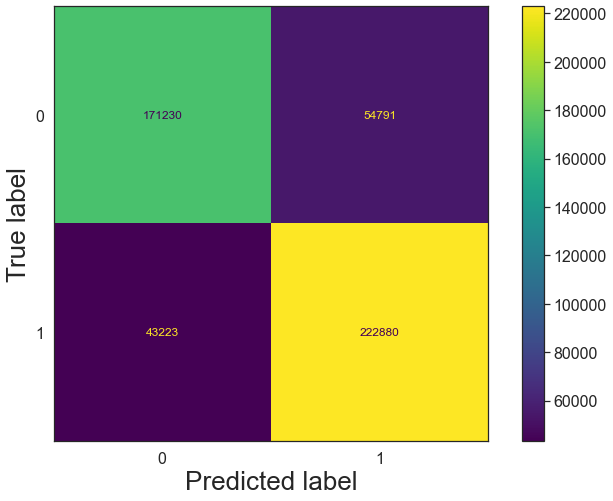

In [29]:
# Confusion matrix of Stacking Ensemble

plot_confusion_matrix(stack_clf, x_test, y_test)
plt.show()

In [30]:
# Sensitivity of the Stacking Ensemble

stack_sy = 222880/(43223 + 222880)
stack_sy

0.8375704144635724